In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from functools import partial

import gymnasium as gym
import numpy as np
import seaborn as sns
import torch as t
from gymnasium.envs.registration import EnvSpec
from matplotlib import pyplot as plt
from rich.pretty import pprint as pp

from bert_sac.models import Actor, BertsAttention, SoftQNetwork
from bert_sac.sac_trainer import AntSAC
from bert_sac.utils import make_env

ppe = partial(pp, expand_all=True)

SEED = 99

In [3]:
device = t.device("cuda:0")
t.set_default_device(device)

In [4]:
envs = gym.vector.SyncVectorEnv([make_env("Ant-v4", seed=SEED)])

In [5]:
envs.get_attr("spec")[0].id

'Ant-v4'

In [6]:
obs = t.tensor(envs.reset(seed=SEED)[0], dtype=t.float32)
obs.shape, obs.device, obs.dtype

(torch.Size([1, 27]), device(type='cuda', index=0), torch.float32)

{
│   'ATT_MASK.shape': torch.Size([9, 27]),
│   'COMPONENTS_MASK.shape': torch.Size([9, 27])
}

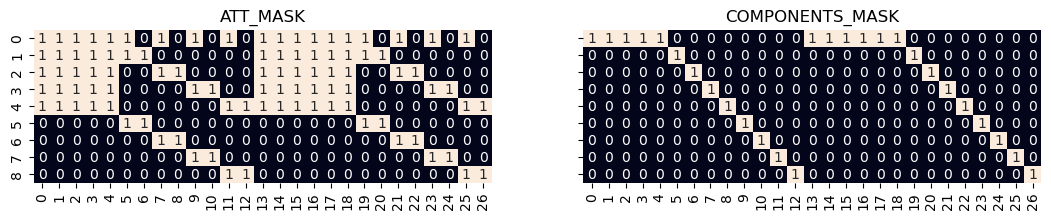

In [7]:
NUM_STRUCT_ELEMENTS = 9

ATT_MASK = t.tensor(
    [
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    ]
)

COMPONENTS_MASK = t.tensor(
    [
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    ]
)

ppe({"ATT_MASK.shape": ATT_MASK.shape, "COMPONENTS_MASK.shape": ATT_MASK.shape})

f, (axl, axr) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(13, 6))
sns.heatmap(ATT_MASK.cpu(), ax=axl, square=True, cbar=False, annot=True)
axl.set_title("ATT_MASK")
axr.set_title("COMPONENTS_MASK")
sns.heatmap(COMPONENTS_MASK.cpu(), ax=axr, square=True, cbar=False, annot=True)
plt.show()

In [8]:
COMPONENTS_MASK.dtype

torch.int64

In [12]:
envs = gym.vector.SyncVectorEnv([make_env("Ant-v4", seed=SEED)])

In [13]:
sac = AntSAC(
    actor_net=Actor,
    critic_net=SoftQNetwork,
    envs=envs,
    device=device,
    num_struct_elements=9,
    attention_mask=ATT_MASK,
    components_mask=COMPONENTS_MASK,
    n_legs=4,
    seed=SEED
)

In [14]:
sac.train(25_000)

 20%|██        | 5001/25000 [00:34<02:17, 145.31it/s]


RuntimeError: shape '[2304, 1, 1, 27]' is invalid for input of size 243